# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase
using Distances

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
data = CSV.read("data.csv")

,1,2,3,4,5,6,7,8,9,10,11
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64
1,3.919,2.6909,0,0,0,0,0,31.4,2,0,0
2,4.17,2.1144,0,0,0,0,0,30.8,1,1,0
3,3.932,3.2512,0,0,0,0,0,26.7,2,4,0
4,3.0,2.7098,0,0,0,0,0,20.0,0,2,0
5,4.236,3.3944,0,0,0,0,0,29.4,2,4,0
6,4.236,3.4286,0,0,0,0,0,28.6,2,4,0
7,5.0,5.0476,1,0,0,0,0,11.1,0,3,0
8,4.525,3.8301,0,0,0,0,0,31.6,3,2,0
9,4.596,3.0777,0,0,0,0,2,44.4,2,0,0


Look at class labels to see if dataset is imbalanced

In [3]:
label_counts = countmap(data[:Class])

Dict{String,Int64} with 2 entries:
  "RB"  => 356
  "NRB" => 699

In [4]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

2-element Array{Float64,1}:
 0.33744075829383885
 0.6625592417061611

Get data ready for training

In [5]:
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,1,4.78264,2.0,4.828,6.496,,,Float64
2,2,3.06951,0.8039,3.0463,9.1775,,,Float64
3,3,0.716588,0,0.0,12,,,Int64
4,4,0.042654,0,0.0,3,,,Int64
5,5,0.980095,0,0.0,36,,,Int64
6,6,0.290047,0,0.0,13,,,Int64
7,7,1.64645,0,1.0,18,,,Int64
8,8,37.0556,0.0,37.5,60.7,,,Float64
9,9,1.3763,0,1.0,24,,,Int64


In [6]:
coerce!(data, :Class=>Multiclass)
schema(data)

┌─────────┬─────────────────────────────────┬───────────────┐
│ _.names │ _.types                         │ _.scitypes    │
├─────────┼─────────────────────────────────┼───────────────┤
│ 1       │ Float64                         │ Continuous    │
│ 2       │ Float64                         │ Continuous    │
│ 3       │ Int64                           │ Count         │
│ 4       │ Int64                           │ Count         │
│ 5       │ Int64                           │ Count         │
│ 6       │ Int64                           │ Count         │
│ 7       │ Int64                           │ Count         │
│ 8       │ Float64                         │ Continuous    │
│ 9       │ Int64                           │ Count         │
│ 10      │ Int64                           │ Count         │
│ 11      │ Int64                           │ Count         │
│ 12      │ Float64                         │ Continuous    │
│ 13      │ Float64                         │ Continuous    │
│ 14    

In [7]:
y, X = unpack(data, ==(:Class), colname->true)

(CategoricalValue{String,UInt32}["RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB", "RB"  …  "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB", "NRB"], 1055×41 DataFrame. Omitted printing of 33 columns
│ Row  │ 1       │ 2       │ 3     │ 4     │ 5     │ 6     │ 7     │ 8       │
│      │ Float64 │ Float64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Float64 │
├──────┼─────────┼─────────┼───────┼───────┼───────┼───────┼───────┼─────────┤
│ 1    │ 3.919   │ 2.6909  │ 0     │ 0     │ 0     │ 0     │ 0     │ 31.4    │
│ 2    │ 4.17    │ 2.1144  │ 0     │ 0     │ 0     │ 0     │ 0     │ 30.8    │
│ 3    │ 3.932   │ 3.2512  │ 0     │ 0     │ 0     │ 0     │ 0     │ 26.7    │
│ 4    │ 3.0     │ 2.7098  │ 0     │ 0     │ 0     │ 0     │ 0     │ 20.0    │
│ 5    │ 4.236   │ 3.3944  │ 0     │ 0     │ 0     │ 0     │ 0     │ 29.4    │
│ 6    │ 4.236   │ 3.4286  │ 0     │ 0     │ 0     │ 0     │ 0     │ 28.6    │
│ 7    │ 5.0     │ 5.0476  │ 1     │ 0     │ 0     │ 0     │ 0     │ 11.

Partition train and test data accoring to class labels

In [8]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class])) # gives 70:30 split

([465, 562, 278, 619, 161, 972, 782, 321, 537, 760  …  12, 913, 471, 13, 1006, 802, 112, 840, 744, 261], [196, 586, 245, 77, 1028, 432, 215, 987, 137, 411  …  975, 610, 886, 848, 731, 1024, 805, 500, 659, 415])

In [9]:
train_counts = countmap(data[train,:Class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

2-element Array{Float64,1}:
 0.33739837398373984
 0.6626016260162602

In [10]:
test_counts = countmap(data[test,:Class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

2-element Array{Float64,1}:
 0.33753943217665616
 0.6624605678233438

In [11]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:]) #only want to standardize on training distribution
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @005.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [12]:
models(matching(X,y))

6-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = RandomForestClassifier, package_name = DecisionTree, ... )
 (name = RandomForestClassifier, package_name = ScikitLearn, ... )

In [13]:
@load KNNClassifier

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @220

## K Nearest Neighbors
* Use different values of k.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/composing_models/
1. https://github.com/KristofferC/NearestNeighbors.jl

#### No Pre-Processing

In [14]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @619

In [15]:
KNN = machine(knn, X, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @619`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @137 trained 0 times.
  args: 
    1:	Source @773 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @251 ⏎ `AbstractArray{Multiclass{2},1}`


In [16]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @137.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @137 trained 1 time.
  args: 
    1:	Source @773 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @251 ⏎ `AbstractArray{Multiclass{2},1}`


In [17]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                               │
├───────────────┼───────────────┼──────────────────────────────────────────┤
│ cross_entropy │ 1.72          │ [1.49, 1.57, 0.68, 3.12, 2.37, 1.11]     │
│ acc           │ 0.812         │ [0.852, 0.75, 0.869, 0.795, 0.79, 0.817] │
└───────────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [[[0.223, 0.511, ..., 0.916], [0.223, 0.916, ..., 0.916], [2.22e-16, 0.223, ..., 0.916], [2.22e-16, 0.916, ..., 2.22e-16], [0.916, 0.223, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 0.223]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [18]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 880
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,)

#### With Pre-Processing

In [19]:
knn = KNNClassifier(K=5)

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @914

In [20]:
KNN = machine(knn, X_stand, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @914`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @349 trained 0 times.
  args: 
    1:	Source @312 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @246 ⏎ `AbstractArray{Multiclass{2},1}`


In [21]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @349.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @349 trained 1 time.
  args: 
    1:	Source @312 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @246 ⏎ `AbstractArray{Multiclass{2},1}`


In [22]:
knn_acc = evaluate!(KNN, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                                 │
├───────────────┼───────────────┼────────────────────────────────────────────┤
│ cross_entropy │ 1.47          │ [1.1, 1.66, 1.29, 0.607, 1.66, 2.54]       │
│ acc           │ 0.856         │ [0.852, 0.858, 0.864, 0.915, 0.835, 0.811] │
└───────────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 36.0, ..., 2.22e-16], [0.223, 0.916, ..., 0.916], [0.223, 0.916, ..., 0.223], [0.916, 2.22e-16, ..., 2.22e-16], [0.511, 2.22e-16, ..., 2.22e-16], [0.916, 0.223, ..., 0.223]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [23]:
# evaluate!(KNN, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [24]:
fitted_params(KNN)

(tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 880
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,)

### GridSearch / RandomSearch

#### Euclidean

In [80]:
knn_grid = KNNClassifier()

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @788

In [81]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=15, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [82]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=15),
                                    resampling=CV(nfolds=6, shuffle=true), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1],
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 15,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @590],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @140

In [83]:
self_tuning_knn = machine(self_tuning_knn_model, X_stand, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=ProbabilisticTunedModel{Grid,…} @140`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{ProbabilisticTunedModel{Grid,…}} @226 trained 0 times.
  args: 
    1:	Source @543 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @589 ⏎ `AbstractArray{Multiclass{2},1}`


In [84]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @226.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 15 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=Resampler{CV,…} @712`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
Evaluating over 15 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @142`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where 

Machine{ProbabilisticTunedModel{Grid,…}} @226 trained 1 time.
  args: 
    1:	Source @543 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @589 ⏎ `AbstractArray{Multiclass{2},1}`


In [85]:
best = fitted_params(self_tuning_knn)
best

(best_model = KNNClassifier @021,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 738
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [86]:
best.best_model

KNNClassifier(
    K = 4,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @021

**Learning Curves**

In [87]:
data_schedule, training_losses, valid_losses = learn_curve(best.best_model, X_stand[train,:], y[train], acc)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (10, 0.9, 0.7027027027027027)
(d, train_metric, valid_metric) = (15, 0.8666666666666667, 0.7027027027027027)
(d, train_metric, valid_metric) = (20, 0.9, 0.7297297297297297)
(d, train_metric, valid_metric) = (25, 0.96, 0.7972972972972973)
(d, train_metric, valid_metric) = (30, 0.9666666666666667, 0.8040540540540541)
(d, train_metric, valid_metric) = (35, 0.9714285714285714, 0.8040540540540541)
(d, train_metric, valid_metric) = (40, 0.9, 0.8108108108108109)
(d, train_metric, valid_metric) = (45, 0.8888888888888888, 0.8243243243243243)
(d, train_metric, valid_metric) = (50, 0.86, 0.8108108108108109)
(d, train_metric, valid_metric) = (55, 0.8909090909090909, 0.8108108108108109)
(d, train_metric, valid_metric) = (60, 0.8666666666666667, 0.7972972972972973)
(d, train_metric, valid_metric) = (65, 0.8307692307692308, 0.7837837837837838)
(d, train_metric, valid_metric) = (70, 0.8142857142857143, 0.7972972972972973)
(d, train_metric, valid_metric) = (75, 0.81333

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


(d, train_metric, valid_metric) = (140, 0.8785714285714286, 0.7567567567567568)
(d, train_metric, valid_metric) = (145, 0.8827586206896552, 0.7837837837837838)
(d, train_metric, valid_metric) = (150, 0.8733333333333333, 0.7905405405405406)
(d, train_metric, valid_metric) = (155, 0.8709677419354839, 0.7837837837837838)
(d, train_metric, valid_metric) = (160, 0.875, 0.8040540540540541)
(d, train_metric, valid_metric) = (165, 0.8787878787878788, 0.777027027027027)
(d, train_metric, valid_metric) = (170, 0.8823529411764706, 0.777027027027027)
(d, train_metric, valid_metric) = (175, 0.8857142857142857, 0.7905405405405406)
(d, train_metric, valid_metric) = (180, 0.8888888888888888, 0.7905405405405406)
(d, train_metric, valid_metric) = (185, 0.8918918918918919, 0.7837837837837838)
(d, train_metric, valid_metric) = (190, 0.8894736842105263, 0.7837837837837838)
(d, train_metric, valid_metric) = (195, 0.8923076923076924, 0.7905405405405406)
(d, train_metric, valid_metric) = (200, 0.9, 0.79054054

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (245, 0.9061224489795918, 0.7905405405405406)
(d, train_metric, valid_metric) = (250, 0.912, 0.777027027027027)
(d, train_metric, valid_metric) = (255, 0.9137254901960784, 0.7702702702702703)
(d, train_metric, valid_metric) = (260, 0.9, 0.7702702702702703)
(d, train_metric, valid_metric) = (265, 0.8905660377358491, 0.777027027027027)
(d, train_metric, valid_metric) = (270, 0.8925925925925926, 0.777027027027027)
(d, train_metric, valid_metric) = (275, 0.8909090909090909, 0.777027027027027)
(d, train_metric, valid_metric) = (280, 0.8857142857142857, 0.7702702702702703)
(d, train_metric, valid_metric) = (285, 0.8842105263157894, 0.7702702702702703)
(d, train_metric, valid_metric) = (290, 0.8862068965517241, 0.7702702702702703)
(d, train_metric, valid_metric) = (295, 0.8813559322033898, 0.7702702702702703)
(d, train_metric, valid_metric) = (300, 0.88, 0.7702702702702703)
(d, train_metric, valid_metric) = (305, 0.8819672131147541, 0.777027027027027)
(d, tra

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (325, 0.8861538461538462, 0.7905405405405406)
(d, train_metric, valid_metric) = (330, 0.8878787878787879, 0.7972972972972973)
(d, train_metric, valid_metric) = (335, 0.8835820895522388, 0.7972972972972973)
(d, train_metric, valid_metric) = (340, 0.8823529411764706, 0.7972972972972973)
(d, train_metric, valid_metric) = (345, 0.8782608695652174, 0.7905405405405406)
(d, train_metric, valid_metric) = (350, 0.8828571428571429, 0.7905405405405406)
(d, train_metric, valid_metric) = (355, 0.8816901408450705, 0.7972972972972973)
(d, train_metric, valid_metric) = (360, 0.8805555555555555, 0.8040540540540541)
(d, train_metric, valid_metric) = (365, 0.8767123287671232, 0.8108108108108109)
(d, train_metric, valid_metric) = (370, 0.8837837837837837, 0.8108108108108109)
(d, train_metric, valid_metric) = (375, 0.8906666666666667, 0.8243243243243243)
(d, train_metric, valid_metric) = (380, 0.8947368421052632, 0.8243243243243243)
(d, train_metric, valid_metric) = (385, 

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (405, 0.891358024691358, 0.831081081081081)
(d, train_metric, valid_metric) = (410, 0.8926829268292683, 0.831081081081081)
(d, train_metric, valid_metric) = (415, 0.8939759036144578, 0.831081081081081)
(d, train_metric, valid_metric) = (420, 0.8928571428571429, 0.831081081081081)
(d, train_metric, valid_metric) = (425, 0.8894117647058823, 0.831081081081081)
(d, train_metric, valid_metric) = (430, 0.8906976744186047, 0.831081081081081)
(d, train_metric, valid_metric) = (435, 0.896551724137931, 0.8445945945945946)
(d, train_metric, valid_metric) = (440, 0.9, 0.8378378378378378)
(d, train_metric, valid_metric) = (445, 0.9011235955056179, 0.8378378378378378)
(d, train_metric, valid_metric) = (450, 0.9022222222222223, 0.8513513513513513)
(d, train_metric, valid_metric) = (455, 0.9032967032967033, 0.8513513513513513)
(d, train_metric, valid_metric) = (460, 0.9, 0.8513513513513513)
(d, train_metric, valid_metric) = (465, 0.9010752688172043, 0.8513513513513513

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (475, 0.8989473684210526, 0.8378378378378378)
(d, train_metric, valid_metric) = (480, 0.8979166666666667, 0.8378378378378378)
(d, train_metric, valid_metric) = (485, 0.8969072164948454, 0.8378378378378378)
(d, train_metric, valid_metric) = (490, 0.8959183673469387, 0.8378378378378378)
(d, train_metric, valid_metric) = (495, 0.896969696969697, 0.8378378378378378)
(d, train_metric, valid_metric) = (500, 0.898, 0.831081081081081)
(d, train_metric, valid_metric) = (505, 0.899009900990099, 0.831081081081081)
(d, train_metric, valid_metric) = (510, 0.903921568627451, 0.8378378378378378)
(d, train_metric, valid_metric) = (515, 0.9009708737864077, 0.8378378378378378)
(d, train_metric, valid_metric) = (520, 0.9019230769230769, 0.8378378378378378)
(d, train_metric, valid_metric) = (525, 0.9028571428571428, 0.8581081081081081)
(d, train_metric, valid_metric) = (530, 0.9018867924528302, 0.8581081081081081)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (535, 0.9009345794392524, 0.8581081081081081)
(d, train_metric, valid_metric) = (540, 0.9, 0.8581081081081081)
(d, train_metric, valid_metric) = (545, 0.9027522935779817, 0.8581081081081081)
(d, train_metric, valid_metric) = (550, 0.9054545454545454, 0.8581081081081081)
(d, train_metric, valid_metric) = (555, 0.9045045045045045, 0.8581081081081081)
(d, train_metric, valid_metric) = (560, 0.9071428571428571, 0.8581081081081081)
(d, train_metric, valid_metric) = (565, 0.9061946902654867, 0.8648648648648649)
(d, train_metric, valid_metric) = (570, 0.9070175438596492, 0.8581081081081081)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (575, 0.9078260869565218, 0.8581081081081081)
(d, train_metric, valid_metric) = (580, 0.9086206896551724, 0.8581081081081081)
(d, train_metric, valid_metric) = (585, 0.905982905982906, 0.8581081081081081)
(d, train_metric, valid_metric) = (590, 0.9084745762711864, 0.8648648648648649)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @021`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(10:5:590, Any[0.9, 0.8666666666666667, 0.9, 0.96, 0.9666666666666667, 0.9714285714285714, 0.9, 0.8888888888888888, 0.86, 0.8909090909090909  …  0.9027522935779817, 0.9054545454545454, 0.9045045045045045, 0.9071428571428571, 0.9061946902654867, 0.9070175438596492, 0.9078260869565218, 0.9086206896551724, 0.905982905982906, 0.9084745762711864], Any[0.7027027027027027, 0.7027027027027027, 0.7297297297297297, 0.7972972972972973, 0.8040540540540541, 0.8040540540540541, 0.8108108108108109, 0.8243243243243243, 0.8108108108108109, 0.8108108108108109  …  0.8581081081081081, 0.8581081081081081, 0.8581081081081081, 0.8581081081081081, 0.8648648648648649, 0.8581081081081081, 0.8581081081081081, 0.8581081081081081, 0.8581081081081081, 0.8648648648648649])

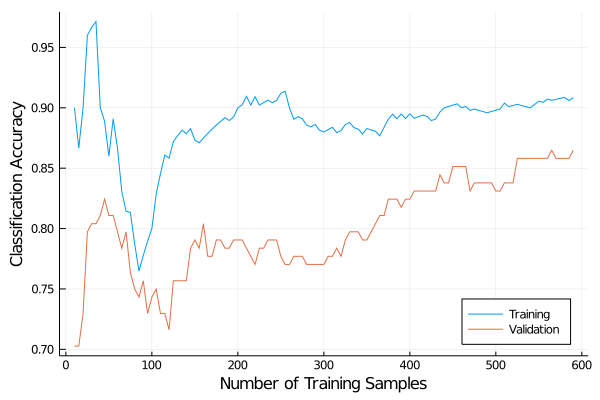

In [88]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

In [89]:
fn = "Figures/KNN_Learning_Curve"
png(replace(fn,'.' => ','))

In [90]:
self_tuning_knn.report.plotting

(parameter_names = ["K"],
 parameter_scales = [:linear],
 parameter_values = Any[13; 11; … ; 14; 2],
 measurements = [0.821138211382114, 0.8211382113821136, 0.8441734417344174, 0.8509485094850948, 0.8536585365853658, 0.8482384823848238, 0.8373983739837398, 0.8265582655826558, 0.8590785907859079, 0.8468834688346883, 0.8631436314363145, 0.8441734417344174, 0.8252032520325203, 0.8279132791327912, 0.8631436314363145],)

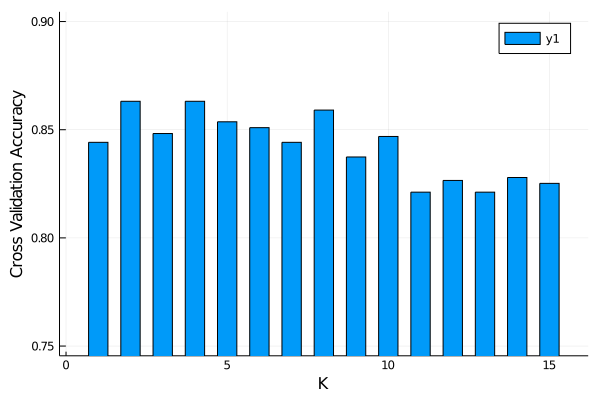

In [91]:
bar(self_tuning_knn.report.plotting.parameter_values[:,1], 
    self_tuning_knn.report.plotting.measurements,
    bar_width=0.6,
    ylims=[0.75, 0.9])
    fillcolor=:red
    fillalpha=0.2
xlabel!("K")
ylabel!("Cross Validation Accuracy")

In [92]:
fn = "Figures/KNN_MCC"
png(replace(fn,'.' => ','))

#### Manhattan

In [114]:
knn_grid = KNNClassifier(metric=Cityblock())

KNNClassifier(
    K = 5,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @382

In [115]:
param1 = :K

r1 = range(knn_grid, param1, lower=1, upper=15, scale=:linear)

MLJBase.NumericRange(Int64, :K, ... )

In [116]:
self_tuning_knn_model = TunedModel(model=knn_grid,
                                    tuning=Grid(goal=15),
                                    resampling=CV(nfolds=6, shuffle=true), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1], 
                                    operation=predict_mode)

ProbabilisticTunedModel(
    model = KNNClassifier(
            K = 5,
            algorithm = :kdtree,
            metric = Chebyshev(),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    tuning = Grid(
            goal = 15,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict_mode,
    range = MLJBase.NumericRange{Int64,MLJBase.Bounded,Symbol}[NumericRange{Int64,…} @590],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
    check_measure = true) @170

In [117]:
self_tuning_knn = machine(self_tuning_knn_model, X_stand, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=ProbabilisticTunedModel{Grid,…} @170`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{ProbabilisticTunedModel{Grid,…}} @500 trained 0 times.
  args: 
    1:	Source @804 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @516 ⏎ `AbstractArray{Multiclass{2},1}`


In [118]:
z = fit!(self_tuning_knn, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @500.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 15 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=Resampler{CV,…} @179`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
Evaluating over 15 metamodels:   0%[>                        ]  ETA: N/A┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @521`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where 

Machine{ProbabilisticTunedModel{Grid,…}} @500 trained 1 time.
  args: 
    1:	Source @804 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @516 ⏎ `AbstractArray{Multiclass{2},1}`


In [119]:
best_Man = fitted_params(self_tuning_knn)
best_Man

(best_model = KNNClassifier @872,
 best_fitted_params = (tree = NearestNeighbors.KDTree{StaticArrays.SArray{Tuple{41},Float64,1,41},Euclidean,Float64}
  Number of points: 738
  Dimensions: 41
  Metric: Euclidean(0.0)
  Reordered: true,),)

In [120]:
best_Man.best_model

KNNClassifier(
    K = 2,
    algorithm = :kdtree,
    metric = Chebyshev(),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @872

**Learning Curves**

In [121]:
data_schedule, training_losses, valid_losses = learn_curve(best_Man.best_model, X_stand[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.9, 0.7027027027027027)
(d, train_metric, valid_metric) = (15, 1.0, 0.75)
(d, train_metric, valid_metric) = (20, 0.95, 0.7905405405405406)
(d, train_metric, valid_metric) = (25, 0.96, 0.7635135135135135)
(d, train_metric, valid_metric) = (30, 0.9666666666666667, 0.7702702702702703)
(d, train_metric, valid_metric) = (35, 0.9714285714285714, 0.777027027027027)
(d, train_metric, valid_metric) = (40, 0.925, 0.7905405405405406)
(d, train_metric, valid_metric) = (45, 0.9333333333333333, 0.7905405405405406)
(d, train_metric, valid_metric) = (50, 0.92, 0.7905405405405406)
(d, train_metric, valid_metric) = (55, 0.8909090909090909, 0.7972972972972973)
(d, train_metric, valid_metric) = (60, 0.8666666666666667, 0.7972972972972973)
(d, train_metric, valid_metric) = (65, 0.8923076923076924, 0.8040540540540541)
(d, train_metric, valid_metric) = (70, 0.8714285714285714, 0.777027027027027)
(d, train_metric, valid_metric) = (75, 0.88, 0.7567567567567568)
(d, train

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (130, 0.9076923076923077, 0.8108108108108109)
(d, train_metric, valid_metric) = (135, 0.9111111111111111, 0.8243243243243243)
(d, train_metric, valid_metric) = (140, 0.9071428571428571, 0.8175675675675675)
(d, train_metric, valid_metric) = (145, 0.9172413793103448, 0.8040540540540541)
(d, train_metric, valid_metric) = (150, 0.9133333333333333, 0.8108108108108109)
(d, train_metric, valid_metric) = (155, 0.9032258064516129, 0.8108108108108109)
(d, train_metric, valid_metric) = (160, 0.9125, 0.8175675675675675)
(d, train_metric, valid_metric) = (165, 0.9151515151515152, 0.8243243243243243)
(d, train_metric, valid_metric) = (170, 0.9117647058823529, 0.8243243243243243)
(d, train_metric, valid_metric) = (175, 0.9142857142857143, 0.8243243243243243)
(d, train_metric, valid_metric) = (180, 0.9166666666666666, 0.8243243243243243)
(d, train_metric, valid_metric) = (185, 0.918918918918919, 0.8243243243243243)
(d, train_metric, valid_metric) = (190, 0.92105263157

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (255, 0.9333333333333333, 0.8243243243243243)
(d, train_metric, valid_metric) = (260, 0.9346153846153846, 0.831081081081081)
(d, train_metric, valid_metric) = (265, 0.9358490566037736, 0.8243243243243243)
(d, train_metric, valid_metric) = (270, 0.9407407407407408, 0.8175675675675675)
(d, train_metric, valid_metric) = (275, 0.9381818181818182, 0.8175675675675675)
(d, train_metric, valid_metric) = (280, 0.9357142857142857, 0.8108108108108109)
(d, train_metric, valid_metric) = (285, 0.9333333333333333, 0.8108108108108109)
(d, train_metric, valid_metric) = (290, 0.9344827586206896, 0.8108108108108109)
(d, train_metric, valid_metric) = (295, 0.9254237288135593, 0.8108108108108109)
(d, train_metric, valid_metric) = (300, 0.9266666666666666, 0.8108108108108109)
(d, train_metric, valid_metric) = (305, 0.9245901639344263, 0.8175675675675675)
(d, train_metric, valid_metric) = (310, 0.9258064516129032, 0.8175675675675675)
(d, train_metric, valid_metric) = (315, 0

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (365, 0.9205479452054794, 0.831081081081081)
(d, train_metric, valid_metric) = (370, 0.9243243243243243, 0.831081081081081)
(d, train_metric, valid_metric) = (375, 0.92, 0.831081081081081)
(d, train_metric, valid_metric) = (380, 0.9210526315789473, 0.831081081081081)
(d, train_metric, valid_metric) = (385, 0.9194805194805195, 0.831081081081081)
(d, train_metric, valid_metric) = (390, 0.9230769230769231, 0.831081081081081)
(d, train_metric, valid_metric) = (395, 0.9189873417721519, 0.831081081081081)
(d, train_metric, valid_metric) = (400, 0.9175, 0.831081081081081)
(d, train_metric, valid_metric) = (405, 0.9209876543209876, 0.831081081081081)
(d, train_metric, valid_metric) = (410, 0.9219512195121952, 0.831081081081081)
(d, train_metric, valid_metric) = (415, 0.9228915662650602, 0.831081081081081)
(d, train_metric, valid_metric) = (420, 0.9214285714285714, 0.8243243243243243)
(d, train_metric, valid_metric) = (425, 0.9176470588235294, 0.824324324324324

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (450, 0.9288888888888889, 0.8243243243243243)
(d, train_metric, valid_metric) = (455, 0.9296703296703297, 0.8243243243243243)
(d, train_metric, valid_metric) = (460, 0.9326086956521739, 0.831081081081081)
(d, train_metric, valid_metric) = (465, 0.9333333333333333, 0.831081081081081)
(d, train_metric, valid_metric) = (470, 0.9319148936170213, 0.831081081081081)
(d, train_metric, valid_metric) = (475, 0.9305263157894736, 0.831081081081081)
(d, train_metric, valid_metric) = (480, 0.93125, 0.8243243243243243)
(d, train_metric, valid_metric) = (485, 0.9298969072164949, 0.8243243243243243)
(d, train_metric, valid_metric) = (490, 0.9285714285714286, 0.8243243243243243)
(d, train_metric, valid_metric) = (495, 0.9292929292929293, 0.831081081081081)
(d, train_metric, valid_metric) = (500, 0.928, 0.831081081081081)
(d, train_metric, valid_metric) = (505, 0.9287128712871288, 0.831081081081081)
(d, train_metric, valid_metric) = (510, 0.9274509803921569, 0.831081081

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (530, 0.9283018867924528, 0.831081081081081)
(d, train_metric, valid_metric) = (535, 0.9327102803738317, 0.8243243243243243)
(d, train_metric, valid_metric) = (540, 0.9296296296296296, 0.8243243243243243)
(d, train_metric, valid_metric) = (545, 0.9302752293577982, 0.8243243243243243)
(d, train_metric, valid_metric) = (550, 0.9309090909090909, 0.8243243243243243)
(d, train_metric, valid_metric) = (555, 0.9315315315315316, 0.831081081081081)
(d, train_metric, valid_metric) = (560, 0.9321428571428572, 0.831081081081081)
(d, train_metric, valid_metric) = (565, 0.9327433628318584, 0.8445945945945946)
(d, train_metric, valid_metric) = (570, 0.9315789473684211, 0.8445945945945946)
(d, train_metric, valid_metric) = (575, 0.9356521739130435, 0.8445945945945946)
(d, train_metric, valid_metric) = (580, 0.9362068965517242, 0.8445945945945946)
(d, train_metric, valid_metric) = (585, 0.935042735042735, 0.8445945945945946)


┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @872`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var

(d, train_metric, valid_metric) = (590, 0.9355932203389831, 0.8445945945945946)


(10:5:590, Any[0.9, 1.0, 0.95, 0.96, 0.9666666666666667, 0.9714285714285714, 0.925, 0.9333333333333333, 0.92, 0.8909090909090909  …  0.9302752293577982, 0.9309090909090909, 0.9315315315315316, 0.9321428571428572, 0.9327433628318584, 0.9315789473684211, 0.9356521739130435, 0.9362068965517242, 0.935042735042735, 0.9355932203389831], Any[0.7027027027027027, 0.75, 0.7905405405405406, 0.7635135135135135, 0.7702702702702703, 0.777027027027027, 0.7905405405405406, 0.7905405405405406, 0.7905405405405406, 0.7972972972972973  …  0.8243243243243243, 0.8243243243243243, 0.831081081081081, 0.831081081081081, 0.8445945945945946, 0.8445945945945946, 0.8445945945945946, 0.8445945945945946, 0.8445945945945946, 0.8445945945945946])

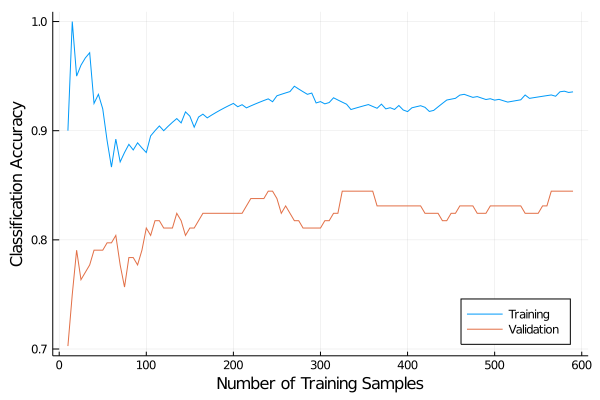

In [122]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

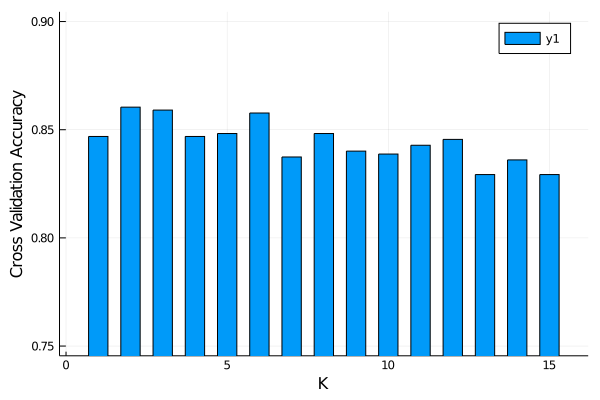

In [123]:
bar(self_tuning_knn.report.plotting.parameter_values[:,1], 
    self_tuning_knn.report.plotting.measurements,
    bar_width=0.6,
    ylims=[0.75, 0.9])
    fillcolor=:red
    fillalpha=0.2
xlabel!("K")
ylabel!("Cross Validation Accuracy")

# Final Results

In [48]:
knn_final = KNNClassifier(K=best.best_model.K)

KNNClassifier(
    K = 8,
    algorithm = :kdtree,
    metric = Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @894

In [49]:
KNN_Final = machine(knn_final, X_stand, y)

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=KNNClassifier @894`:
│ scitype(X) = Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}
│ input_scitype(model) = Table{var"#s44"} where var"#s44"<:(AbstractArray{var"#s13",1} where var"#s13"<:Continuous).
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:77


Machine{KNNClassifier} @502 trained 0 times.
  args: 
    1:	Source @055 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @616 ⏎ `AbstractArray{Multiclass{2},1}`


In [50]:
fit!(KNN, rows=train)

┌ Info: Training Machine{KNNClassifier} @349.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{KNNClassifier} @349 trained 8 times.
  args: 
    1:	Source @312 ⏎ `Table{Union{AbstractArray{Continuous,1}, AbstractArray{Count,1}}}`
    2:	Source @246 ⏎ `AbstractArray{Multiclass{2},1}`


In [51]:
ŷ = MLJ.predict(KNN, X_stand[test,:]);

In [52]:
cross_entropy(ŷ, y[test]) |> mean

1.3989417665622235

In [53]:
acc(ŷ, y[test])

0.8485804416403786

In [93]:
c = confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using: negative='NRB' and positive='RB'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:83


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │     NRB     │     RB      │
├─────────────┼─────────────┼─────────────┤
│     NRB     │     185     │     23      │
├─────────────┼─────────────┼─────────────┤
│     RB      │     25      │     84      │
└─────────────┴─────────────┴─────────────┘


In [94]:
precision(c)

0.7706422018348624

In [95]:
recall(c)

0.7850467289719626

In [98]:
25/(185+25)

0.11904761904761904

In [99]:
23/(23+84)

0.21495327102803738

In [100]:
misclassification_rate(c)

0.1514195583596214